<a href="https://colab.research.google.com/github/martintmv-git/photogrammetry/blob/main/Experiments/Stockpile%20volume%20computation/Stockpile_volume_computation_Open3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stockpile volume computation with Open3D
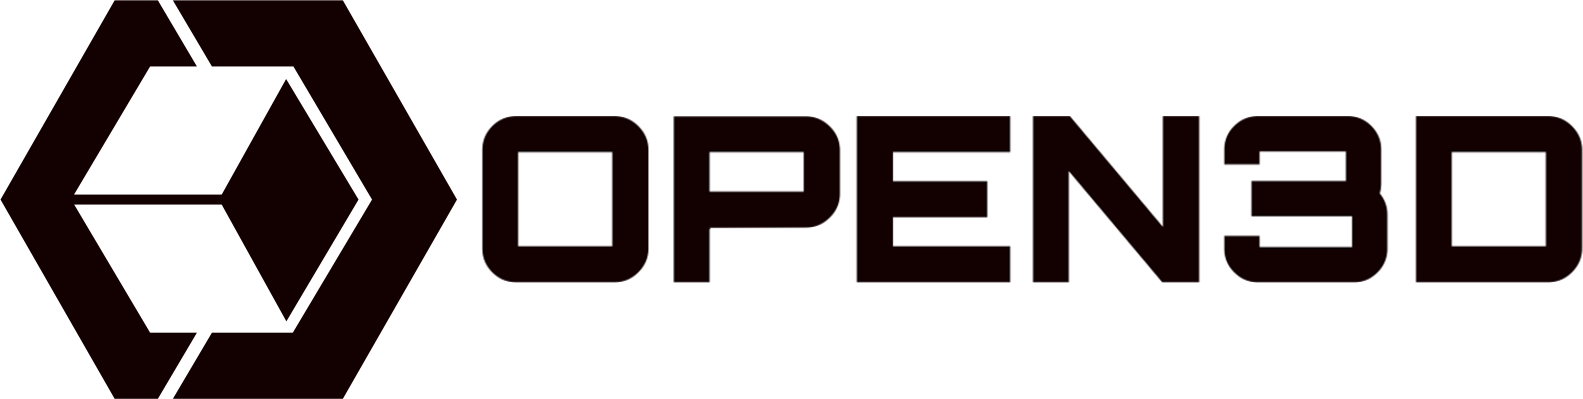

In [8]:
import open3d as o3d
import numpy as np
import math
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import math
from functools import reduce

In [9]:
%pip show open3d

Name: open3d
Version: 0.18.0
Summary: Open3D: A Modern Library for 3D Data Processing.
Home-page: https://www.open3d.org
Author: Open3D Team
Author-email: info@open3d.org
License: MIT
Location: c:\programdata\anaconda3\envs\open3denv\lib\site-packages
Requires: configargparse, dash, ipywidgets, nbformat, numpy, werkzeug
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [10]:
pcd = o3d.io.read_point_cloud("stockpile.ply")
axes = o3d.geometry.TriangleMesh.create_coordinate_frame()

In [12]:
plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                         ransac_n=3,
                                         num_iterations=10000)


[a, b, c, d] = plane_model

In [13]:
plane_pcd = pcd.select_by_index(inliers)
plane_pcd.paint_uniform_color([1.0, 0, 0])
stockpile_pcd = pcd.select_by_index(inliers, invert=True)
stockpile_pcd.paint_uniform_color([0, 0, 1.0])

o3d.visualization.draw_geometries([plane_pcd, stockpile_pcd, axes])

In [14]:
plane_pcd = plane_pcd.translate((0,0,d/c))
stockpile_pcd = stockpile_pcd.translate((0,0,d/c))

cos_theta = c / math.sqrt(a**2 + b**2 + c**2)
sin_theta = math.sqrt((a**2+b**2)/(a**2 + b**2 + c**2))
u_1 = b / math.sqrt(a**2 + b**2 )
u_2 = -a / math.sqrt(a**2 + b**2)

rotation_matrix = np.array([[cos_theta + u_1**2 * (1-cos_theta), u_1*u_2*(1-cos_theta), u_2*sin_theta],
                            [u_1*u_2*(1-cos_theta), cos_theta + u_2**2*(1- cos_theta), -u_1*sin_theta],
                            [-u_2*sin_theta, u_1*sin_theta, cos_theta]])

plane_pcd.rotate(rotation_matrix)
stockpile_pcd.rotate(rotation_matrix)
o3d.visualization.draw_geometries([plane_pcd, stockpile_pcd, axes])

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


In [15]:
o3d.visualization.draw_geometries([stockpile_pcd])

In [16]:
cl, ind = stockpile_pcd.remove_statistical_outlier(nb_neighbors=30,
                                                    std_ratio=2.0)
stockpile_pcd = stockpile_pcd.select_by_index(ind)
o3d.visualization.draw_geometries([stockpile_pcd])

In [17]:
downpdc = stockpile_pcd.voxel_down_sample(voxel_size=0.05)
xyz = np.asarray(downpdc.points)
xy_catalog = []
for point in xyz:
    xy_catalog.append([point[0], point[1]])
tri = Delaunay(np.array(xy_catalog))

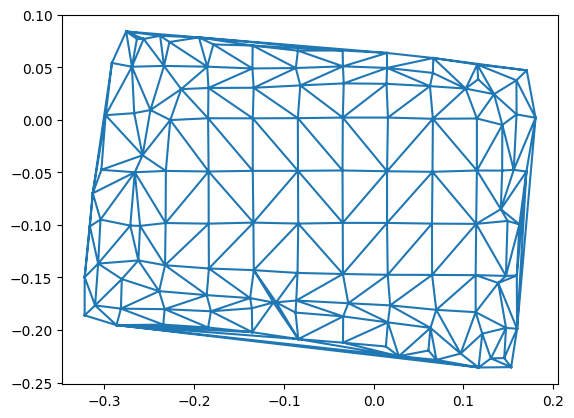

In [18]:
xy_catalog = np.array(xy_catalog)
plt.triplot(xy_catalog[:,0], xy_catalog[:,1], tri.simplices)

In [19]:
surface = o3d.geometry.TriangleMesh()
surface.vertices = o3d.utility.Vector3dVector(xyz)
surface.triangles = o3d.utility.Vector3iVector(tri.simplices)
surface.paint_uniform_color([0, 0, 1.0])
o3d.visualization.draw_geometries([surface], mesh_show_wireframe=True)

In [20]:
def get_triangles_vertices(triangles, vertices):
    triangles_vertices = []
    for triangle in triangles:
        new_triangles_vertices = [vertices[triangle[0]], vertices[triangle[1]], vertices[triangle[2]]]
        triangles_vertices.append(new_triangles_vertices)
    return np.array(triangles_vertices)

In [21]:
def volume_under_triangle(triangle):
    p1, p2, p3 = triangle
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    x3, y3, z3 = p3
    return abs((z1+z2+z3)*(x1*y2-x2*y1+x2*y3-x3*y2+x3*y1-x1*y3)/6)

In [22]:
volume = reduce(lambda a, b:  a + volume_under_triangle(b), get_triangles_vertices(surface.triangles, surface.vertices), 0)
print(f"The volume of the stockpile is: {round(volume, 4)} m3")

The volume of the stockpile is: 0.01 m3
